# Brain Tumor Detector

## Definition of the Dataset

We decided to use the dataset : https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

It contains:
- 253 MRI images in total
- 98 No Tumor (38.74%)
- 155 Yes Tumor (61.26%)


## Installation and Import Packages

### Installation

In [88]:
%pip install numpy
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing Packages 

In [89]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys


## Reading MRI Images

This section reads and processes MRI images of brain scans. It’s divided into two parts: loading images with tumors and loading images without tumors.

In [90]:
# Load and process images from the dataset, return as numpy array
def load_and_process_images(path, size=(128, 128)):
    images = []
    for file in glob.iglob(path):
        img = cv2.imread(file)
        img = cv2.resize(img, size)
        # Convert from BGR to RGB for visualization consistency
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)


healthy_images = load_and_process_images('data/no/*.jpg')
infected_images = load_and_process_images('data/yes/*.jpg')

## Visualizing Brain MRI Images

The plot_images function is defined to visualize images from each category, "healthy" and "infected":

In [91]:
def plot_images(images, title):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Shape: {img.shape}')
    plt.show()

The images parameter receives a random list of images of each category.

<Figure size 1600x900 with 0 Axes>

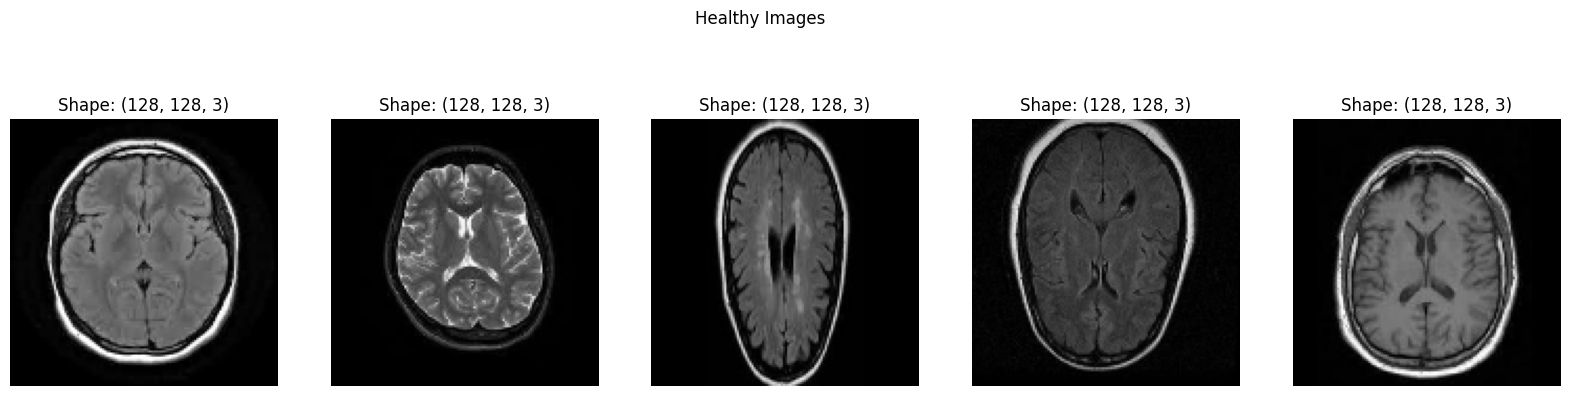

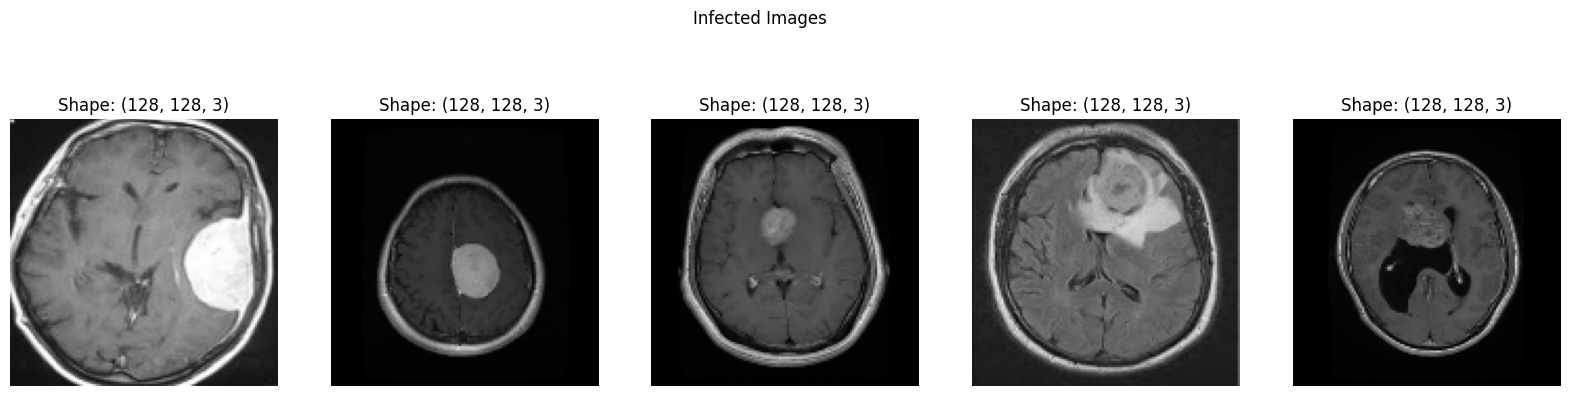

In [92]:
plt.figure(figsize=(16,9))

# Plot some healthy and infected images to visualize the data
plot_images(healthy_images[np.random.choice(healthy_images.shape[0], 5, replace=False)], 'Healthy Images')
plot_images(infected_images[np.random.choice(infected_images.shape[0], 5, replace=False)], 'Infected Images')

### Create Torch Dataset Class
#### What is Pytorch's Abstract Dataset Class

In [97]:
class Dataset(object): #mParent Dataset class
    def __getitem__ (self, index):
        raise NotImplementedError
    
    def __len__ (self):
        raise NotImplementedError
    
    def __add__(self, other):
        return ConcatDataset([self, other])

### Creating MRI custom dataset class

In [ ]:
class MRI(Dataset): # inheriting from the parend dataset
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __getitem__(self, index):
        sample = {'image': self.images [index], 'label': self.labels[index]}
        return sample
    def __len__(self):
        return self.images.shape[0]

In [99]:
s1 = [4,55,66,43]
d1 = MRI(s1)

s2 = [7,8,669,463]
d2 = MRI(s2)

In [102]:
d = d1 + d2

In [104]:
len(d)

8